In [2]:
import numpy as np
import nibabel
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import mne
from mne.transforms import apply_trans
from mne.io.constants import FIFF

from pathlib import Path

In [3]:
subjects_dir = Path('.')
subject = 'Bukhov'

<OrthoSlicer3D: C:\Users\Lenovo\1stereoEEG\Bukhov\mri\T1.mgz (256, 256, 256)>

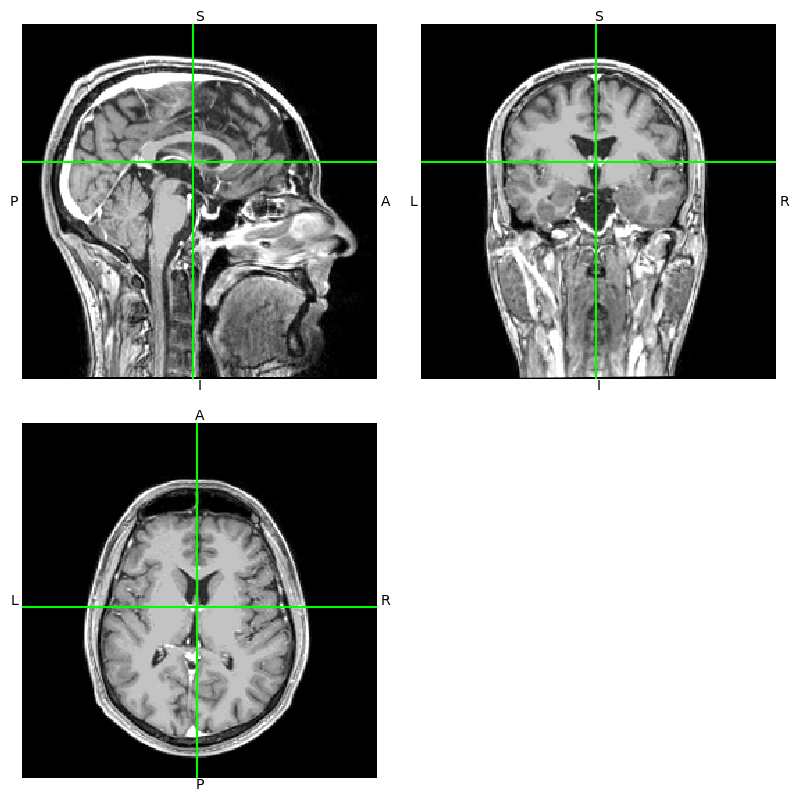

In [4]:
t1 = nibabel.load("C:\\Users\\Lenovo\\1stereoEEG\\Bukhov\\mri\\T1.mgz")
t1.orthoview()

In [5]:
data = np.asarray(t1.dataobj)
print(data.shape)


(256, 256, 256)


In [6]:
# A value data[i, j, k] at a given index triplet (i, j, k) corresponds to some real-world 
#physical location (x, y, z) in space
data[120, 120, 120]

38

In [7]:
data[122, 119, 102]

104

 During acquisition the relationship between the voxel indices (i, j, k) and the physical location (x, y, z) in the scanner’s native coordinate frame is saved in the image’s affine transformation.

In [8]:
print(t1.affine)
vox = np.array([122, 119, 102])
xyz_ras = apply_trans(t1.affine, vox)
print('Our voxel has real-world coordinates {}, {}, {} (mm)'
      .format(*np.round(xyz_ras, 3)))

[[-1.00000000e+00 -9.31322575e-10  4.26553015e-10  1.29920425e+02]
 [ 3.29964678e-09  5.82076609e-11  1.00000000e+00 -9.98544617e+01]
 [ 0.00000000e+00 -9.99999940e-01  0.00000000e+00  1.23294914e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Our voxel has real-world coordinates 7.92, 2.146, 4.295 (mm)


In [9]:
ras_coords_mm = np.array([8, 2, 7])
inv_affine = np.linalg.inv(t1.affine)
i_, j_, k_ = np.round(apply_trans(inv_affine, ras_coords_mm)).astype(int)
print('Our real-world coordinates correspond to voxel ({}, {}, {})'
      .format(i_, j_, k_))

Our real-world coordinates correspond to voxel (122, 116, 102)


In [10]:
def imshow_mri(data, img, vox, xyz, suptitle):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots(1, figsize=(6, 6))
    codes = nibabel.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    ax.imshow(data[i], vmin=10, vmax=120, cmap='pink', origin='lower')
    ax.axvline(k, color='y')
    ax.axhline(j, color='y')
    for kind, coords in xyz.items():
        annotation = ('{}: {}, {}, {} mm'
                      .format(kind, *np.round(coords).astype(int)))
        text = ax.text(k, j, annotation, va='baseline', ha='right',
                       color=(1, 1, 0.7))
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()])
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig

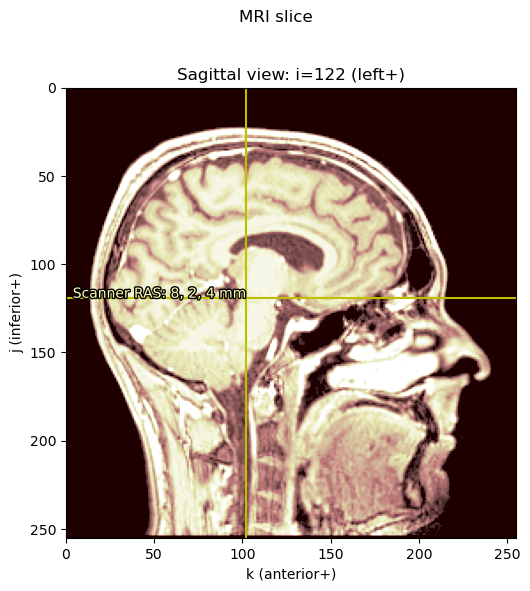

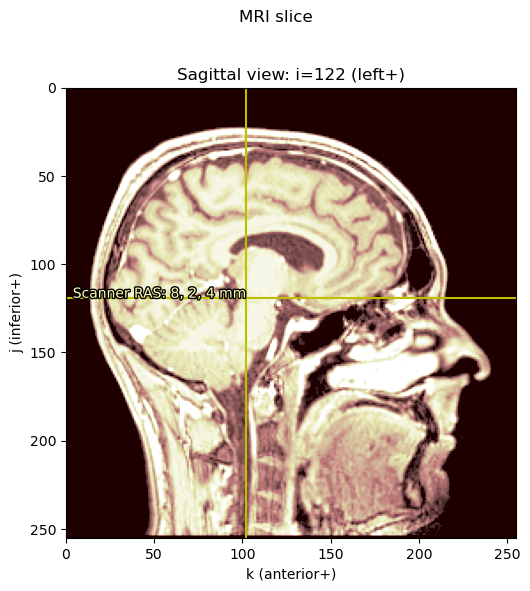

In [11]:
vox = np.array([122, 119, 102])
imshow_mri(data, t1, vox, {'Scanner RAS': xyz_ras}, 'MRI slice')

[[-1.00000000e+00 -9.31322575e-10  4.26553015e-10  1.29920425e+02]
 [ 3.29964678e-09  5.82076609e-11  1.00000000e+00 -9.98544617e+01]
 [ 0.00000000e+00 -9.99999940e-01  0.00000000e+00  1.23294914e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[  -1.    0.    0.  128.]
 [   0.    0.    1. -128.]
 [   0.   -1.    0.  128.]
 [   0.    0.    0.    1.]]


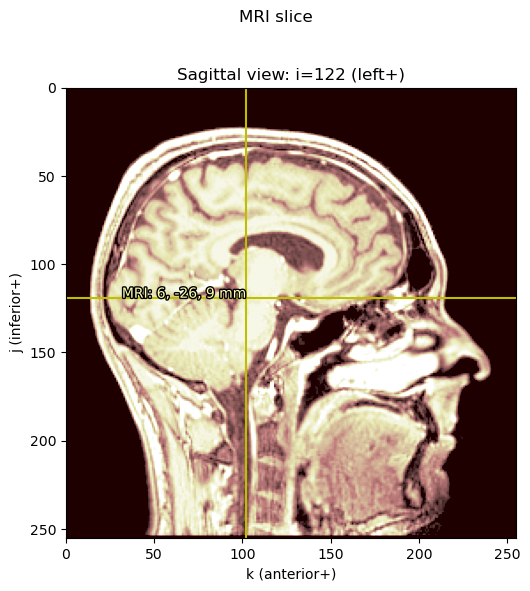

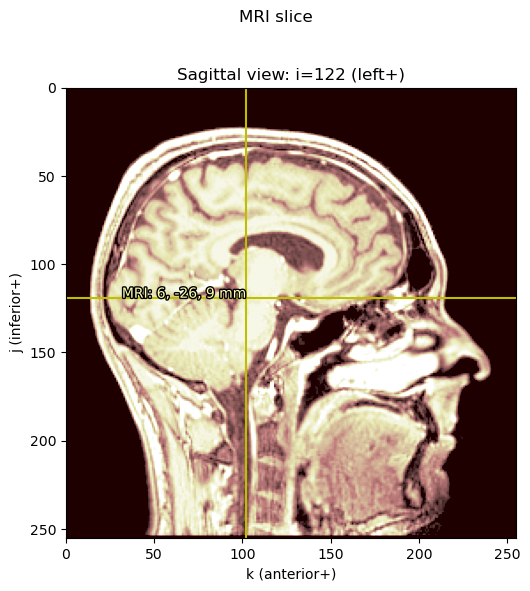

In [12]:
Torig = t1.header.get_vox2ras_tkr()
print(t1.affine)
print(Torig)
xyz_mri = apply_trans(Torig, vox)
imshow_mri(data, t1, vox, dict(MRI=xyz_mri), 'MRI slice')

In [19]:
fiducials = mne.coreg.get_mni_fiducials(subject, subjects_dir=subjects_dir)
nasion_mri = [d for d in fiducials if d['ident'] == FIFF.FIFFV_POINT_NASION][0]
print(nasion_mri)  # note it's in Freesurfer MRI coords

<DigPoint |     Nasion : (4.0, 84.2, 9.5) mm       : MRI (surface RAS) frame>


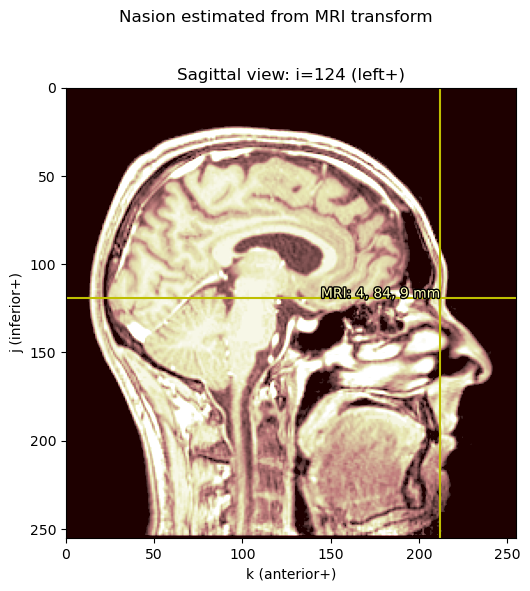

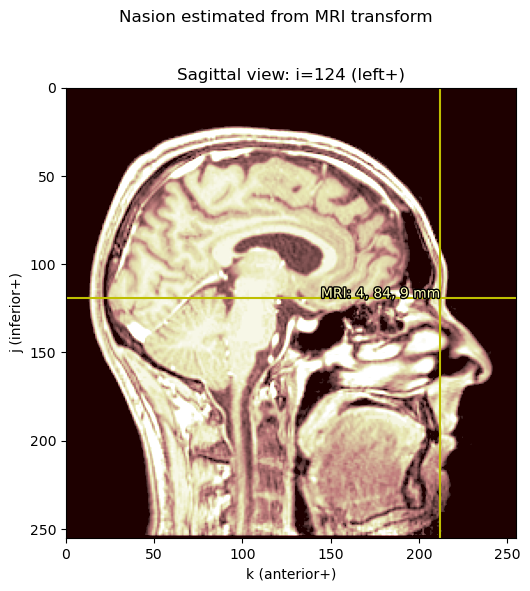

In [20]:
nasion_mri = nasion_mri['r'] * 1000  # meters → millimeters
nasion_vox = np.round(
    apply_trans(np.linalg.inv(Torig), nasion_mri)).astype(int)
imshow_mri(data, t1, nasion_vox, dict(MRI=nasion_mri),
           'Nasion estimated from MRI transform')

In [16]:
nasion_vox

array([124, 119, 212])

Видимо в едф файле в отличие от фиф нет данных о head coordinate frame

In [16]:
#не актуально
info = mne.io.read_info("C:\\Users\\Lenovo\\1lebedev\\stereoEEG\\Patient6Attempt1(Damaged)(Speach) (1).edf")
nasion_head = [d for d in info['dig'] if
               d['kind'] == FIFF.FIFFV_POINT_CARDINAL and
               d['ident'] == FIFF.FIFFV_POINT_NASION][0]
print(nasion_head)  # note it's in "head" coordinates

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lenovo\\1lebedev\\stereoEEG\\Patient6Attempt1(Damaged)(Speach) (1).edf'

In [17]:
#не актуально
trans = mne.read_trans(data_path / 'MEG' / 'sample' /
                       'sample_audvis_raw-trans.fif')

# first we transform from head to MRI, and *then* convert to millimeters
nasion_dig_mri = apply_trans(trans, nasion_head['r']) * 1000

# ...then we can use Torig to convert MRI to voxels:
nasion_dig_vox = np.round(
    apply_trans(np.linalg.inv(Torig), nasion_dig_mri)).astype(int)
imshow_mri(data, t1, nasion_dig_vox, dict(MRI=nasion_dig_mri),
           'Nasion transformed from digitization')

NameError: name 'data_path' is not defined

### Using FreeSurfer’s surface reconstructions

In [18]:
fname = "C:\\Users\\Lenovo\\1stereoEEG\\Bukhov\\surf\\rh.white"
rr_mm, tris = mne.read_surface(fname)
print(f'rr_mm.shape == {rr_mm.shape}')
print(f'tris.shape == {tris.shape}')
print(f'rr_mm.max() = {rr_mm.max()}')  # just to show that we are in mm

rr_mm.shape == (135622, 3)
tris.shape == (271240, 3)
rr_mm.max() = 88.19853210449219


In [20]:
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(600, 600), bgcolor='w', scene=False)
gray = (0.5, 0.5, 0.5)
renderer.mesh(*rr_mm.T, triangles=tris, color=gray)
view_kwargs = dict(elevation=90, azimuth=0)  # camera at +X with +Z up
mne.viz.set_3d_view(
    figure=renderer.figure, distance=350, focalpoint=(0., 0., 40.),
    **view_kwargs)
renderer.show()

In [64]:
rr_mm.shape

(135622, 3)

In [67]:
tris.shape

(271240, 3)

In [69]:
tris.max()

135621

In [21]:
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(600, 600), bgcolor='w', scene=False)
gray = (0.5, 0.5, 0.5)
renderer.mesh(*rr_mm.T, triangles=tris, color=gray, opacity=0.5)
#view_kwargs = dict(elevation=90, azimuth=0)  # camera at +X with +Z up
mne.viz.set_3d_view(
    figure=renderer.figure, distance=350, focalpoint=(0., 0., 40.),
    **view_kwargs)
renderer.show()

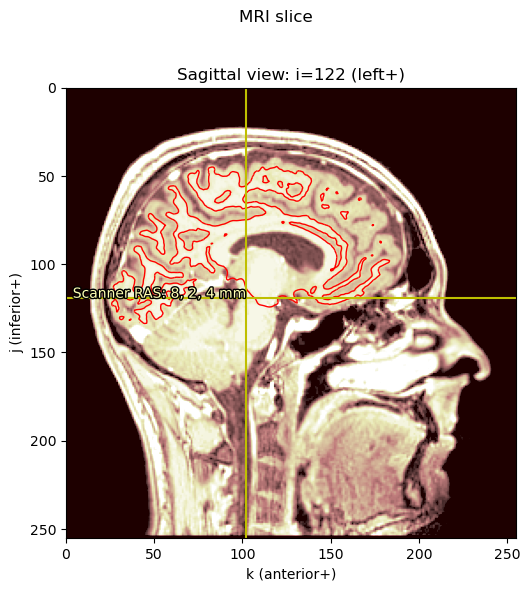

In [23]:
rr_vox = apply_trans(np.linalg.inv(Torig), rr_mm)
fig = imshow_mri(data, t1, vox, {'Scanner RAS': xyz_ras}, 'MRI slice')
# Based on how imshow_mri works, the "X" here is the last dim of the MRI vol,
# the "Y" is the middle dim, and the "Z" is the first dim, so now that our
# points are in the correct coordinate frame, we need to ask matplotlib to
# do a tricontour slice like:
fig.axes[0].tricontour(rr_vox[:, 2], rr_vox[:, 1], tris, rr_vox[:, 0],
                       levels=[vox[0]], colors='r', linewidths=1.0,
                       zorder=1)

### Cortical alignment (spherical)

In [46]:
type(renderer)

mne.viz.backends._qt._Renderer

In [51]:
k

(Actor (0x1b3f3d9b040)
   Center:                     (0.0, 150.0, 0.0)
   Pickable:                   True
   Position:                   (0.0, 0.0, 0.0)
   Scale:                      (1.0, 1.0, 1.0)
   Visible:                    True
   X Bounds                    -1.000E+02, 1.000E+02
   Y Bounds                    5.000E+01, 2.500E+02
   Z Bounds                    -1.000E+02, 1.000E+02
   User matrix:                Unset
   Has mapper:                 True
 
 Property (0x1b381b5bb20)
   Ambient:                     0.0
   Ambient color:               Color(name='white', hex='#ffffffff')
   Anisotropy:                  0.0
   Color:                       Color(name='white', hex='#ffffffff')
   Culling:                     "none"
   Diffuse:                     1.0
   Diffuse color:               Color(name='white', hex='#ffffffff')
   Edge color:                  Color(name='black', hex='#000000ff')
   Interpolation:               "Phong"
   Lighting:                    True
   

In [22]:
renderer_kwargs = dict(bgcolor='w')
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 400), scene=False, **renderer_kwargs)
curvs = [
    (mne.surface.read_curvature(subjects_dir / subj / 'surf' / 'rh.curv',
                                binary=False) > 0).astype(float)
    for subj in ('Bukhov', 'fsaverage') for _ in range(2)]
fnames = [subjects_dir / subj / 'surf' / surf
          for subj in ('Bukhov', 'fsaverage')
          for surf in ('rh.white', 'rh.sphere')]
y_shifts = [-450, -150, 450, 150]
z_shifts = [-40, 0, -30, 0]
for name, y_shift, z_shift, curv in zip(fnames, y_shifts, z_shifts, curvs):
    this_rr, this_tri = mne.read_surface(name)
    this_rr += [0, y_shift, z_shift]
    renderer.mesh(*this_rr.T, triangles=this_tri, color=None, scalars=curv,opacity = 0.5,
                  colormap='copper_r', vmin=-0.2, vmax=1.2)
    k = renderer.mesh(*this_rr.T, triangles=this_tri, color=None, scalars=curv,opacity = 0.5,
                  colormap='copper_r', vmin=-0.2, vmax=1.2)
zero = [0., 0., 0.]
width = 50.
y = np.sort(y_shifts)
y = (y[1:] + y[:-1]) / 2. - width / 2.
renderer.quiver3d(zero, y, zero,
                  zero, [1] * 3, zero, 'k', width, 'arrow')
view_kwargs['focalpoint'] = (0., 0., 0.)
mne.viz.set_3d_view(figure=renderer.figure, distance=1050, **view_kwargs)
renderer.show()

###### это сфер преобразование арбузы

In [44]:
cyan = '#66CCEE'
purple = '#AA3377'
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 800), scene=False, **renderer_kwargs)
fnames = [subjects_dir / subj / 'surf' / 'rh.sphere'
          for subj in ('Bukhov', 'fsaverage')]
colors = [cyan, purple]
for name, color in zip(fnames, colors):
    this_rr, this_tri = mne.read_surface(name)
    renderer.mesh(*this_rr.T, triangles=this_tri, color=color,
                  representation='wireframe')
mne.viz.set_3d_view(figure=renderer.figure, distance=20, **view_kwargs)
renderer.show()

In [26]:
this_rr.shape

(163842, 3)

###### You can see that the fsaverage (purple) mesh is uniformly spaced, and the mesh for subject “sample” (in cyan) has been deformed along the spherical surface by FreeSurfe

#### Делаем грани более редкими - не выйдет, тут нужен Bem. кажется, мы просто делаем извилины менее угловатыми

In [27]:
src = mne.read_source_spaces(subjects_dir / 'Bukhov' / 'bem' /
                             'sample-oct-6-src.fif')
print(src)

blue = '#4477AA'
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 800), scene=False, **renderer_kwargs)
rr_sph, _ = mne.read_surface(fnames[0])
for tris, color in [(src[1]['tris'], cyan), (src[1]['use_tris'], blue)]:
    renderer.mesh(*rr_sph.T, triangles=tris, color=color,
                  representation='wireframe')
mne.viz.set_3d_view(figure=renderer.figure, distance=20, **view_kwargs)
renderer.show()

FileNotFoundError: File does not exist: C:\Users\Lenovo\1stereoEEG\Bukhov\bem\sample-oct-6-src.fif

#### FreeSurfer’s MNI affine transformation

In [36]:
xyz

array([[-60,  -1,  20]])

In [23]:
brain = mne.viz.Brain('Bukhov', 'lh', 'white', cortex=(0.4, 0.1, 0.1), alpha=0.4, subjects_dir=subjects_dir,
                      background='w')
xyz = np.array([[-60, -1, 20]])
brain.add_foci(xyz, hemi='lh', color='k')
brain.show_view('lat')

In [24]:
mri_mni_trans = mne.read_talxfm(subject, subjects_dir)
print(mri_mni_trans)
xyz_mni = apply_trans(mri_mni_trans, xyz / 1000.) * 1000.
print(np.round(xyz_mni, 1))

<Transform | MRI (surface RAS)->MNI Talairach>
[[ 1.024537   -0.048565    0.015448    0.00132044]
 [ 0.091156    1.027164    0.26718698 -0.00431985]
 [-0.017194   -0.208984    1.06800494 -0.02728488]
 [ 0.          0.          0.          1.        ]]
[[-59.8  -5.5  -4.7]]


In [ ]:
xyz_mni

In [41]:
brain = mne.viz.Brain('fsaverage', 'lh', 'white', subjects_dir=subjects_dir,
                      background='w')
brain.add_foci(xyz_mni, hemi='lh', color='k')
brain.show_view('lat')

NameError: name 'xyz_mni' is not defined

In [29]:
brain.__dict__

{'_hemis': ('lh',),
 '_view_layout': 'vertical',
 '_title': 'fsaverage',
 '_interaction': 'trackball',
 '_bg_color': (1.0, 1.0, 1.0),
 '_fg_color': (0.0, 0.0, 0.0),
 '_subplot_shape': (1, 1),
 'time_viewer': False,
 '_hash': 1670240665414227900,
 '_block': False,
 '_hemi': 'lh',
 '_units': 'mm',
 '_alpha': 1.0,
 '_subject': 'fsaverage',
 '_subjects_dir': 'C:\\Users\\Lenovo\\1stereoEEG',
 '_views': ['lateral'],
 '_times': None,
 '_vertex_to_label_id': {},
 '_annotation_labels': {},
 '_labels': {'lh': [], 'rh': []},
 '_unnamed_label_id': 0,
 '_annots': {'lh': [], 'rh': []},
 '_layered_meshes': {'lh': <mne.viz._3d_overlay._LayeredMesh at 0x18d3cddca90>},
 '_actors': {},
 '_elevation_rng': [15, 165],
 '_lut_locked': None,
 '_cleaned': False,
 '_silhouette': {'color': (1.0, 1.0, 1.0),
  'line_width': 2,
  'alpha': 1.0,
  'decimate': 0.9},
 'silhouette': False,
 '_scalar_bar': None,
 '_time_label_added': False,
 '_data': {'lh': {'foci': array([[-59.79425523,  -5.47263579,  -4.68416025]])}},


In [30]:
brain._data

{'lh': {'foci': array([[-59.79425523,  -5.47263579,  -4.68416025]])}}